In [ ]:
# Entendimento e Preparação dos Dados

import pandas as pd

df = pd.read_csv('twitter_training.csv', encoding='latin1')

df_separado = df.iloc[:, 0].str.split(';', expand = True)

# Selecionar as primeiras 4 colunas e atribuir um nome
df_separado = df_separado.iloc[:, :4]
df_separado.columns = ['ID', 'Informações', 'Tipo', 'Comentarios']

# Remover espaços em branco
df_separado = df_separado.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df_separado['ID'] = pd.to_numeric(df_separado['ID'], errors ='coerce')

print(df_separado.isnull().sum())
df_separado = df_separado.dropna()

df = df_separado

#Remoção de Valores Nulos
df = df.dropna()

#Verificação de Duplicatas
df = df.drop_duplicates()

df = df.drop(columns=['num_separadores'], errors='ignore')

print(df.info())
print(df.head())

In [ ]:
#Pré-processamento de Dados

#(a) Remova URLs, menções, hashtags, caracteres especiais, números, etc.

import re 

def limpar_text(texto):
    texto = re.sub(r'http\S+', '', texto)  # Remove URLs
    texto = re.sub(r'@\w+', '', texto)     # Remove menções
    texto = re.sub(r'#\w+', '', texto)     # Remove hashtags
    texto = re.sub(r'[^A-Za-z\s]', '', texto)  # Remove caracteres especiais
    texto = texto.lower()                   # Converte para minúsculas
    return texto

df['Comentarios_limpos'] = df['Comentarios'].apply(limpar_text)

print(df.head())

In [ ]:
#(b) Tokenização e Remoção de Stopwords

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

#carrega a lista de palavras irrelevantes da língua inglesa
stop_words = set(stopwords.words('english')) 

# função para remover stopwords(palavras irrelevantes)
def remover_stopwords(texto):
    tokens = word_tokenize(texto)
    tokens_filtrados = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens_filtrados)

#Aplicação da Função ao DataFrame
df['Comentarios_limpos'] = df['Comentarios_limpos'].apply(remover_stopwords)


In [5]:
# (c) Vamos utilizar a técnica de stemming para reduzir as palavras ao seu radical (ou raiz)

from nltk import PorterStemmer

# Inicializa o PorterStemmer
stemmer = PorterStemmer()

def stemizar(texto):
    tokens = word_tokenize(texto)
    tokens_stemizados = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens_stemizados)

df['Comentarios_limpos'] = df['Comentarios_limpos'].apply(stemizar)

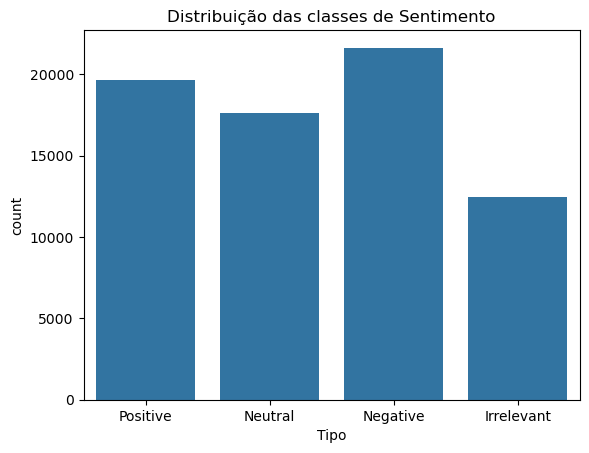

In [22]:
# Análise Exploratória dos Dados (EDA)
        #a. Distribuição das Classes

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Tipo', data=df)
plt.title('Distribuição das classes de Sentimento')
plt.show()


In [ ]:
#b. Palavras Mais Frequentes: Visualizar as palavras mais comuns em cada classe de sentimento.

from collections import Counter

#Filtrar Comentários por Tipo
positivo = df[df['Tipo'] == 'Positive']['Comentarios_limpos']
negativo = df[df['Tipo'] == 'Negative']['Comentarios_limpos']
neutro = df[df['Tipo'] == 'Neutral']['Comentarios_limpos']

#Contagem de Palavras
contador_positivo = Counter(' '.join(positivo).split())
contador_negativo = Counter(' '.join(negativo).split())
contador_neutro = Counter(' '.join(neutro).split())

#Mostrar as Palavras Mais Comuns
print(contador_positivo.most_common(20), '\n')
print(contador_negativo.most_common(20), '\n')
print(contador_neutro.most_common(20), '\n')


In [ ]:
#Preparação para Modelagem
        # a) Divisão dos Dados

from sklearn.model_selection import train_test_split

x = df['Comentarios_limpos']
y = df['Tipo']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Verificar o tamanho dos conjuntos
print(f'Tamanho do conjunto de treinamento: {x_train.shape[0]}')
print(f'Tamanho do conjunto de teste: {x_test.shape[0]}')

In [9]:
# b. Vetorização do Texto

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
x_train_vect = vectorizer.fit_transform(x_train)
x_test_vect = vectorizer.transform(x_test)


In [ ]:
#Regressão Logística

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

modelo = LogisticRegression(max_iter=1000)
modelo.fit(x_train_vect, y_train)

y_pred = modelo.predict(x_test_vect)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f'Acurácia: {accuracy_score(y_test, y_pred)}')


In [ ]:
#Avaliação do modelo: Validação Cruzada

from sklearn.model_selection import cross_val_score

scores = cross_val_score(modelo, x_train_vect, y_train, cv=5, scoring='accuracy')
print(f'Acurácia média com CV: {scores.mean()}')


In [ ]:
#7. Ajuste de Hiperparâmetros (Hyperparameter Tuning)
        #a. Utilizando Grid Search:

from sklearn.model_selection import GridSearchCV

parametros = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

grid = GridSearchCV(LogisticRegression(), parametros, cv=5, scoring='accuracy')
grid.fit(x_train_vect, y_train)

print(f'Melhores parâmetros: {grid.best_params_}')
print(f'Melhor acurácia: {grid.best_score_}')


In [21]:
import joblib

joblib.dump(modelo, 'modelo_sentimento_Twitter.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']